# OpenAI o3
---


| Parameter           | Value                | Description                                                                                   |
|---------------------|----------------------|-----------------------------------------------------------------------------------------------|
| trainer_name        | DummyTrainer         | Name of the trainer                                                                           |
| mode                | inference            | Mode of operation (inference, training)                                                       |
| model_id            | o3-2025-04-16        | Model ID                                        |
| api_key_name        | OPENAI_O3_KEY        | API key name                                                                                  |
| type                | LLM                  | Type of model (convML for conventional ML, convDL for conventional DL, LLM for large language models) |
| verbose             | 2                    | Verbosity level                                                                               |
| reasoning_effort    | medium               | Reasoning effort level (low, medium, high)                                                    |
| max_new_tokens      | 30000                | Maximum number of new tokens                                                                  |
| max_length          | 30000                | Maximum length of input sequences                                                             |
| temperature         | 0.4                  | Temperature for sampling (0.0 = greedy sampling)                                              |

In [1]:
# Imports
import os
import sys
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

sys.path.append(r"C:\Users\janbe\Documents\GitHub Repos\pulse")
from src.eval.llm_analyzer import LLMAnalyzer
from src.eval.pulse_score import PULSEScoreCalculator

## Analysis of different prompting approaches
---

In [3]:
model_id = "o3"

base_output_dir = (
    r"C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark"
)
model_output_dir = os.path.join(base_output_dir, "llms", model_id)
results_output_dir = os.path.join(base_output_dir, r"results_output")
results_output_jsons = os.path.join(results_output_dir, "jsons")
results_json_path = f"{model_id}_results.json"

prompt_approaches = os.listdir(model_output_dir)
for i, approach in enumerate(prompt_approaches, 1):
    print(f"{i}. {approach}")


best_prompt_approach = None
results_dict = {}
mdata_dict = {}
cost_df = pd.DataFrame()

for prompt_approach in prompt_approaches:
    if not os.path.isdir(os.path.join(model_output_dir, prompt_approach)):
        continue

    print("=" * 50)
    print(f"\nPrompting Approach {prompt_approach}\n")

    cat_files = LLMAnalyzer.categorize_files(
        [os.path.join(model_output_dir, prompt_approach)],
        verbose=False,
    )

    df_mdata = LLMAnalyzer.load_metadata(
        cat_files["metadata_files"], verbose=True
    )

    summary = LLMAnalyzer.print_approach_summary(
        df_mdata, input_token_cost=2, output_token_cost=8
    )

    # Filter for final prediction step if agent is used
    if "Step Name" in df_mdata.columns:
        df_mdata = df_mdata[df_mdata["Step Name"] == "final_prediction"].reset_index(
            drop=True
        )

    ps = PULSEScoreCalculator()
    pulse_score = ps.calculate_pulse_score_from_raw_data(
        df=df_mdata,
    )
    pulse_score["model_id"] = model_id
    pulse_score["prompting_id"] = prompt_approach
    pulse_score_temp = pulse_score["overall"]["overall_score"]
    results_dict[prompt_approach] = pulse_score
    mdata_dict[prompt_approach] = df_mdata
    cost_df[prompt_approach] = [
        summary["input_cost"].sum(),
        summary["output_cost"].sum(),
        summary["thinking_cost"].sum(),
        summary["total_cost"].sum(),
    ]

    cost_df.index = ["input_cost", "output_cost", "thinking_cost", "total_cost"]
    if best_prompt_approach is None or pulse_score_temp > best_prompt_approach[1]:

        best_prompt_approach = (prompt_approach, pulse_score_temp)

display(cost_df)
print(
    f"\nBest prompt approach: {best_prompt_approach[0]} with PULSE score: {best_prompt_approach[1]}"
)

# Save results as json. Uses pulse-result format
json_output_path = os.path.join(results_output_jsons, f"{model_id}_results.json")
final_json = LLMAnalyzer.save_results_dict_as_json(results_dict, json_output_path)

1. hybrid_reasoning_agent_preprocessor
2. liu_2023_few_shot_preprocessor
3. sarvari_2024_aggregation
4. zhu_2024a_cot_preprocessor
5. zhu_2024b_one_shot_preprocessor
6. zhu_2024b_zero_shot_preprocessor

Prompting Approach hybrid_reasoning_agent_preprocessor

Extracting metadata from files:
Model Name: OpenAIo3, Task: aki, Dataset: eicu, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: aki, Dataset: hirid, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: aki, Dataset: miiv, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: mortality, Dataset: eicu, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: mortality, Dataset: hirid, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: mortality, Dataset: miiv, Timestamp: 20250708_120104
Model Name: OpenAIo3, Task: sepsis, Dataset: eicu, Timestamp: 20250711_111851
Model Name: OpenAIo3, Task: sepsis, Dataset: hirid, Timestamp: 20250711_111851
Model Name: OpenAIo3, Task: sepsis, Dataset: miiv, Timestamp: 20250711_111851

===

,hybrid_reasoning_agent_preprocessor,liu_2023_few_shot_preprocessor,sarvari_2024_aggregation,zhu_2024a_cot_preprocessor,zhu_2024b_one_shot_preprocessor,zhu_2024b_zero_shot_preprocessor
input_cost,33.609940,108.101850,22.366676,49.723916,69.369396,43.443884
output_cost,90.797288,39.215632,40.799032,40.539376,37.204216,37.117144
thinking_cost,0.000000,295.271424,291.926016,302.616576,274.581504,275.033088
total_cost,124.407228,442.588906,355.091724,392.879868,381.155116,355.594116



Best prompt approach: hybrid_reasoning_agent_preprocessor with PULSE score: 56.79070471001675
Saved 54 result entries to C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark\results_output\jsons\o3_results.json


Summary Metrics of all Prompting Appraches

C:\Users\janbe\Documents\GitHub Repos\pulse\src\eval\llm_analyzer.py:953: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = plot_df.groupby(["Group", "Metric"], as_index=False).agg(


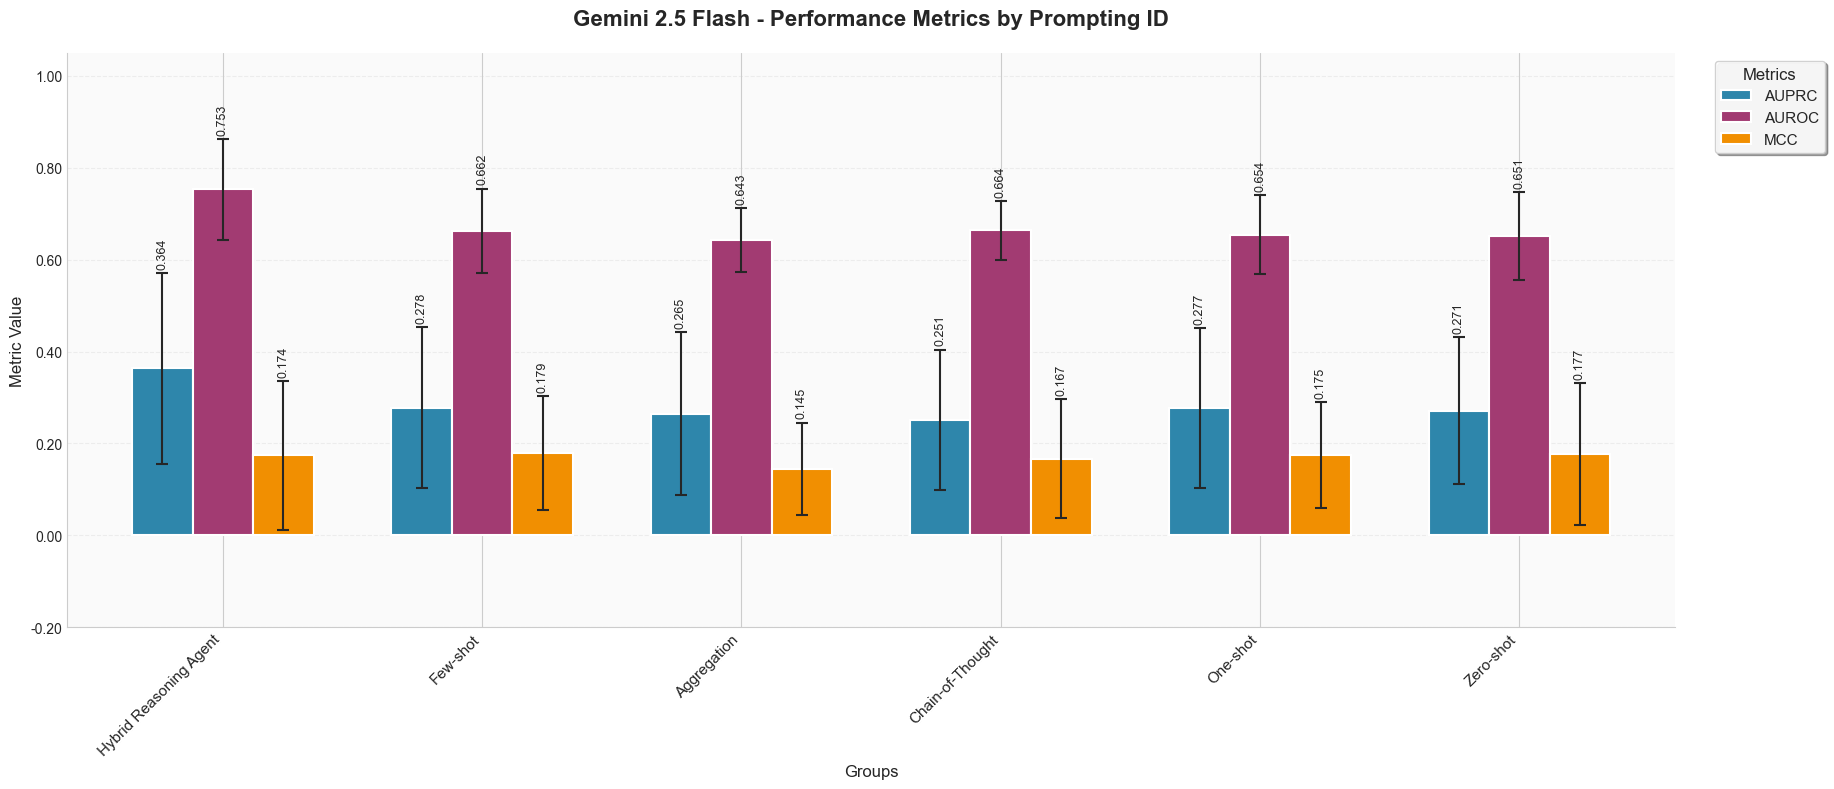

In [4]:
df_results = LLMAnalyzer.load_metrics_from_prompt_approaches(
    model_output_dir, prompt_approaches
)



LLMAnalyzer.plot_metrics(
    df_results, group=["prompting_id"], title_prefix="Gemini 2.5 Flash - "
)

Metrics per Prompt and Task

C:\Users\janbe\Documents\GitHub Repos\pulse\src\eval\llm_analyzer.py:953: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = plot_df.groupby(["Group", "Metric"], as_index=False).agg(


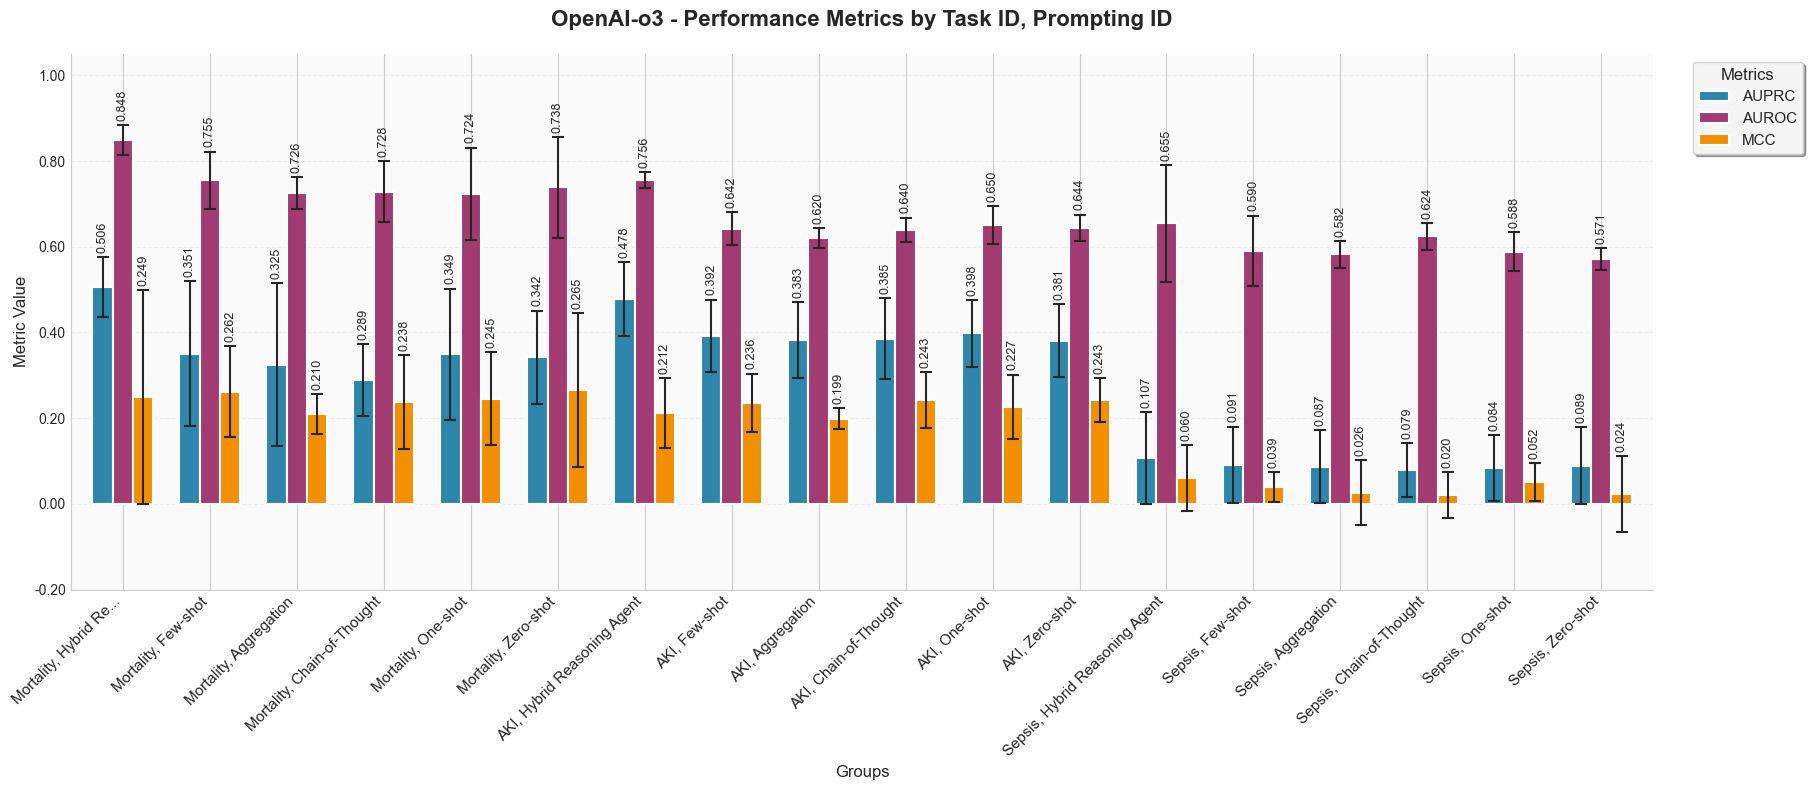

In [5]:
LLMAnalyzer.plot_metrics(
    df_results,
    group=["task_id", "prompting_id"],
    title_prefix="OpenAI-o3 - ",
)

---